In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch_directml
device = torch_directml.device()

In [3]:
from gensim.models import KeyedVectors

embeddings_kv = KeyedVectors.load_word2vec_format('./data/glove.6B.300d.w2v.txt', binary=False)


In [4]:
from datasets import load_dataset

dataset_train = load_dataset("tweet_eval", "sentiment", split="train")
dataset_test = load_dataset("tweet_eval", "sentiment", split="test")
dataset_train.set_format(type="torch", columns=["text", "label"])
dataset_test.set_format(type="torch", columns=["text", "label"])

Found cached dataset tweet_eval (/home/hgoz/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Found cached dataset tweet_eval (/home/hgoz/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


In [5]:
dataset_train

Dataset({
    features: ['text', 'label'],
    num_rows: 45615
})

In [6]:
embeddings = torch.tensor(embeddings_kv.vectors)

In [7]:
label_to_idx = {
    'none': 0,
    'against': 1,
    'favor': 2,
}
idx_to_label = {
    0: 'none',
    1: 'against',
    2: 'favor',
}

In [8]:
class AttentionHead(nn.Module):
    """Scaled Dot-Product Attention"""
    
    def __init__(self, d_model, dk):
        super(AttentionHead, self).__init__()
        
        # Attention layer
        self.w_q = nn.Linear(d_model, dk)
        self.w_k = nn.Linear(d_model, dk)
        self.w_v = nn.Linear(d_model, dk)
        self.softmax = nn.Softmax(dim=-1)
        
        # Feed Forward layer
        self.fc = nn.Linear(dk, d_model)
        
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        # Apply linear transformations
        q = self.w_q(x).view(batch_size, seq_len, -1)
        k = self.w_k(x).view(batch_size, -1, seq_len)
        v = self.w_v(x)
        
        # Calculate context
        attention_scores = torch.bmm(q, k) / math.sqrt(d_model)
        attention_weights = self.softmax(attention_scores) 
        context = torch.bmm(attention_weights, v)

        output = self.softmax(self.fc(context))

        return output


class LayerNorm(nn.Module):
    
    def __init__(self, normalized_shape):
        super().__init__()
        
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, x):    
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + 1e-5)  + self.beta


class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads):
        super(TransformerEncoder, self).__init__()
    
        # Multi-headed Attention
        dh = d_model // n_heads
        self.heads = nn.ModuleList([AttentionHead(d_model, dh) for _ in range(n_heads)])
        self.linear = nn.Linear(n_heads*d_model, d_model)
        self.ln1 = LayerNorm(d_model)
        self.drop1 = nn.Dropout(0.3)

        # Feed Forward
        self.ff1 = nn.Linear(d_model, d_model*4)
        self.ff2 = nn.Linear(d_model*4, d_model)
        self.ln2 = LayerNorm(d_model)
        self.drop2 = nn.Dropout(0.3)
    
    def forward(self, x):
        # batch_size, seq_len, d_model = x.shape

        # Multi-head Attention -> Add & Norm
        multi_head = self.linear(torch.cat([h(x) for h in self.heads], dim=-1))
        x = self.drop1(self.ln1(x + multi_head))

        # Feed Forward -> Add & Norm
        ffn = self.ff2(F.relu(self.ff1(x)))
        x = self.drop2(self.ln2(x + ffn))

        return x


class MyTransformer(nn.Module):
    def __init__(self, sequence_length, n_heads, n_hidden, num_classes):
        super(MyTransformer, self).__init__()

        d_model = embeddings.shape[1]
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)

        # Positional Encodings
        pos_enc = torch.zeros(1, sequence_length, d_model)
        for pos in range(sequence_length):
            for i in range(0, d_model, 2):
                pos_enc[0, pos, i] = math.sin(pos / (10000 ** ((i)/d_model)))
                pos_enc[0, pos, i + 1] = math.cos(pos / (10000 ** ((i + 1)/d_model)))
        self.positional = pos_enc.to(device)
        
        self.encoders = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_hidden)])

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # batch_size, seq_len, d_model = x.shape
        x = self.embedding(x)
        
        x += self.positional[:, :]

        for enc in self.encoders:
            x = enc(x)

        # Classification
        y_pred = F.log_softmax(self.fc(x), dim=1)
        return y_pred[:, -1, :]


In [9]:
def calc_dataset_stats(dataset):
    lengths = [len(text.split(' ')) for text in dataset['text']]
    max_length = max(lengths)
    length_counts = sum(lengths)  
    num_texts = len(dataset['text'])
    avg_length = length_counts / num_texts
    return max_length, length_counts, num_texts, avg_length

max_length_train, length_counts_train, num_texts_train, avg_length_train = calc_dataset_stats(dataset_train)
max_length_test, length_counts_test, num_texts_test, avg_length_test = calc_dataset_stats(dataset_test)

print("Train Set:"    
       "\n\t- Max length: {}" 
       "\n\t- Total length count: {}"  
       "\n\t- Number of texts: {}"
       "\n\t- Average length: {}"
          .format(max_length_train, length_counts_train, num_texts_train, avg_length_train))

print("Test Set:"
       "\n\t- Max length: {}"
       "\n\t- Total length count: {}"     
       "\n\t- Number of texts: {}"  
       "\n\t- Average length: {}"
          .format(max_length_test, length_counts_test, num_texts_test, avg_length_test))

Train Set:
	- Max length: 52
	- Total length count: 883580
	- Number of texts: 45615
	- Average length: 19.370382549599913
Test Set:
	- Max length: 37
	- Total length count: 183711
	- Number of texts: 12284
	- Average length: 14.95530771735591


In [10]:
def preprocess(text, max_length):
    l = []
    for w in text.split(' '):
        if w in embeddings_kv:
            l.append(embeddings_kv.key_to_index[w])
    # PAD using dots
    l += [embeddings_kv.key_to_index['.']] * (max_length - len(l))    
    return l

train_inputs = [preprocess(text, max_length_train) for text in dataset_train['text']]
train_inputs = torch.tensor(train_inputs)

In [11]:
train_inputs = []
for text in dataset_train['text']:
    l = []
    for w in text.split(' '):
        if w in embeddings_kv:
            l.append(embeddings_kv.key_to_index[w])
    # PAD using dots
    for i in range(max_length_train - len(l)):
        l.append(embeddings_kv.key_to_index['.'])
    train_inputs.append(l)
torch.tensor(train_inputs[:3]).shape

torch.Size([3, 52])

In [12]:
test_inputs = []
for text in dataset_test['text']:
    l = []
    for w in text.split(' '):
        if w in embeddings_kv:
            l.append(embeddings_kv.key_to_index[w])
    # PAD using dots
    for i in range(max_length_train - len(l)):
        l.append(embeddings_kv.key_to_index['.'])
    test_inputs.append(l)
torch.tensor(test_inputs[:3]).shape

torch.Size([3, 52])

In [13]:
from torch.utils.data import Dataset, DataLoader

class TweetDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [19]:
model = MyTransformer(max_length_train, 20, 3, 3).to(device)
# model.load_state_dict(torch.load('model.pt'))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
train_losses = []
epochs = []

Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400
0.8367642164230347
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400
1.0692839622497559
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400
1.0054075717926025
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400
0.9579233527183533
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400
1.06624174118042
Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300


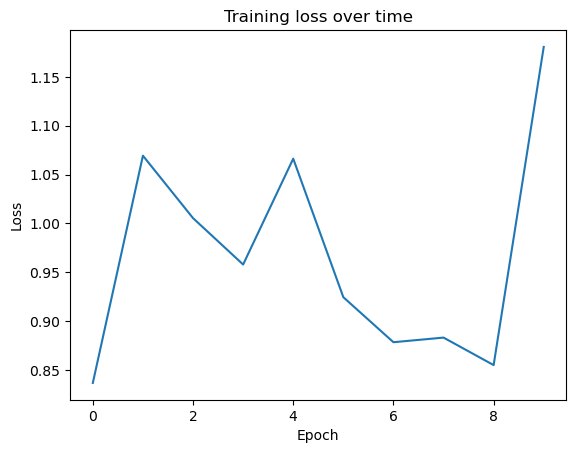

In [21]:
batch_size = 32
train_loader = DataLoader(TweetDataset(torch.tensor(train_inputs), dataset_train['label']), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TweetDataset(torch.tensor(test_inputs), dataset_test['label']), batch_size=batch_size, shuffle=True)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        x, y = batch[0].to(device), batch[1].to(device)
        # Forward pass: compute predicted y by passing x to the model.
        output = model(x)

        # Calculate the loss
        loss = loss_fn(output, y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the Tensors it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Print batch number   
        if i % 100 == 0:
            print(f"Batch {i}")
    
    print(loss.item())
    # Record loss and epoch values
    # if (epoch + 1) % 2 == 0:
    train_losses.append(loss.item())
    epochs.append(epoch)
    torch.save(model.state_dict(), 'model.pt')
    


import matplotlib.pyplot as plt
plt.plot(torch.arange(0, len(epochs), 1), train_losses, 1, label="Loss")
plt.title('Training loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
model.eval()
num_total = 0
sum_correct = 0

with torch.no_grad():
    for x, y in test_loader:  
        y = y.to(device)
        output = model(x.to(device))
        y_pred = torch.argmax(output, dim=1)      
        sum_correct += (y_pred == y).sum().item() 
        num_total += y.shape[0]
        

accuracy = sum_correct / num_total

# Print the accuracy        
print("The accuracy of the testing set: {:.2f}%".format(accuracy * 100))

The accuracy of the testing set: 50.21%


In [23]:
for x, y in zip(test_inputs[:15], dataset_test['label'][:15]):
    text = ' '.join([embeddings_kv.index_to_key[i] for i in x if i != 2])
    print(idx_to_label[y.item()].upper(), ' ' * 5, text)

AGAINST       what do these naked have to do with not even like
AGAINST       had a blue penis while was with
AGAINST       but think the victims are going to be
FAVOR       think may be finally in with the in crowd
NONE       and now and are running out of
AGAINST       now took drug test live on prove they are not
AGAINST       many more days until opening
FAVOR       
AGAINST       and all around is to cease and held - the
NONE       take away illegals and dead people and wins popular vote
AGAINST       interesting security vulnerability - albeit not for the everyday car thief
AGAINST       1. number 5.
FAVOR       cute little dance
NONE       privatizes & does away with what will base feel about a big one
NONE       loves yelling in the crowded
